In [8]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum


In [64]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch


class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch
# Определение задач рабочего процесса
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)
# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )
# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Определение классов земного покрова
# Необходимо найти данные о землепользовании (где и как непонятно)
class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [44]:
# Load geojson file
country = gpd.read_file('D:/YandexDisk/курсач_4/districts84_v.geojson')

# Convert CRS to UTM_35N
country_crs = CRS.UTM_35N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())


In [65]:
# Выбор источника данных базовой карты
land_cover_path = 'D:/YandexDisk/курсач_4/polygons_att.shp' if use_smaller_patches \
    else 'D:/YandexDisk/курсач_4/polygons_att.shp'

# Чтение источника данных базовой карты в переменную land_cover 
land_cover = gpd.read_file(land_cover_path)

# Приведение координатной системы к UTM_35N
# Convert CRS to UTM_35N
country_crs = CRS.UTM_35N
land_cover = land_cover.to_crs(crs={'init': CRS.ogc_string(country_crs)})


land_cover_val = [0,1,2,3,4,5,6,7,8,9,10]
land_cover_array = []
for val in land_cover_val:
    temp = land_cover[land_cover.lulcid == val]
    temp.reset_index(drop=True, inplace=True)
    land_cover_array.append(temp)
    del temp

rshape = (FeatureType.MASK, 'IS_VALID')

land_cover_task_array = []
for el, val in zip(land_cover_array, land_cover_val):
    land_cover_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'LULC'),
        vector_data=el,
        raster_value=val,
        raster_shape=rshape,
        raster_dtype=np.uint8))   

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    *land_cover_task_array,
    save
)    

In [66]:
%%time

# Execute the workflow
time_interval = ['2018-01-01', '2018-12-31'] # time interval for the SH request

# Show progress bar
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(bbox_list[patchIDs]):

    # define additional parameters of the workflow
    extra_param = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }

    workflow.execute(extra_param)
    pbar.update(1)

c:\users\frolui\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
c:\users\frolui\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
c:\users\frolui\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Wall time: 6min 54s


In [73]:
# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example

# Выберите номер центрального контейнера
ID = 1549 if use_smaller_patches else 190 #1549

# Obtain surrounding patches
# Получение окружающих контейнеров

# Инициализация patchIDs (type = list)
patchIDs = []

# patchIDS - список контейнеров, окружающих ID контейнер - 1549
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)       

In [71]:
# подготовка информации о выбранных EOPatches
# Prepare info of selected EOPatches

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
gdf = gpd.GeoDataFrame(df,
                       crs={'init': CRS.ogc_string(country_crs)},
                       geometry=geometry)

poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

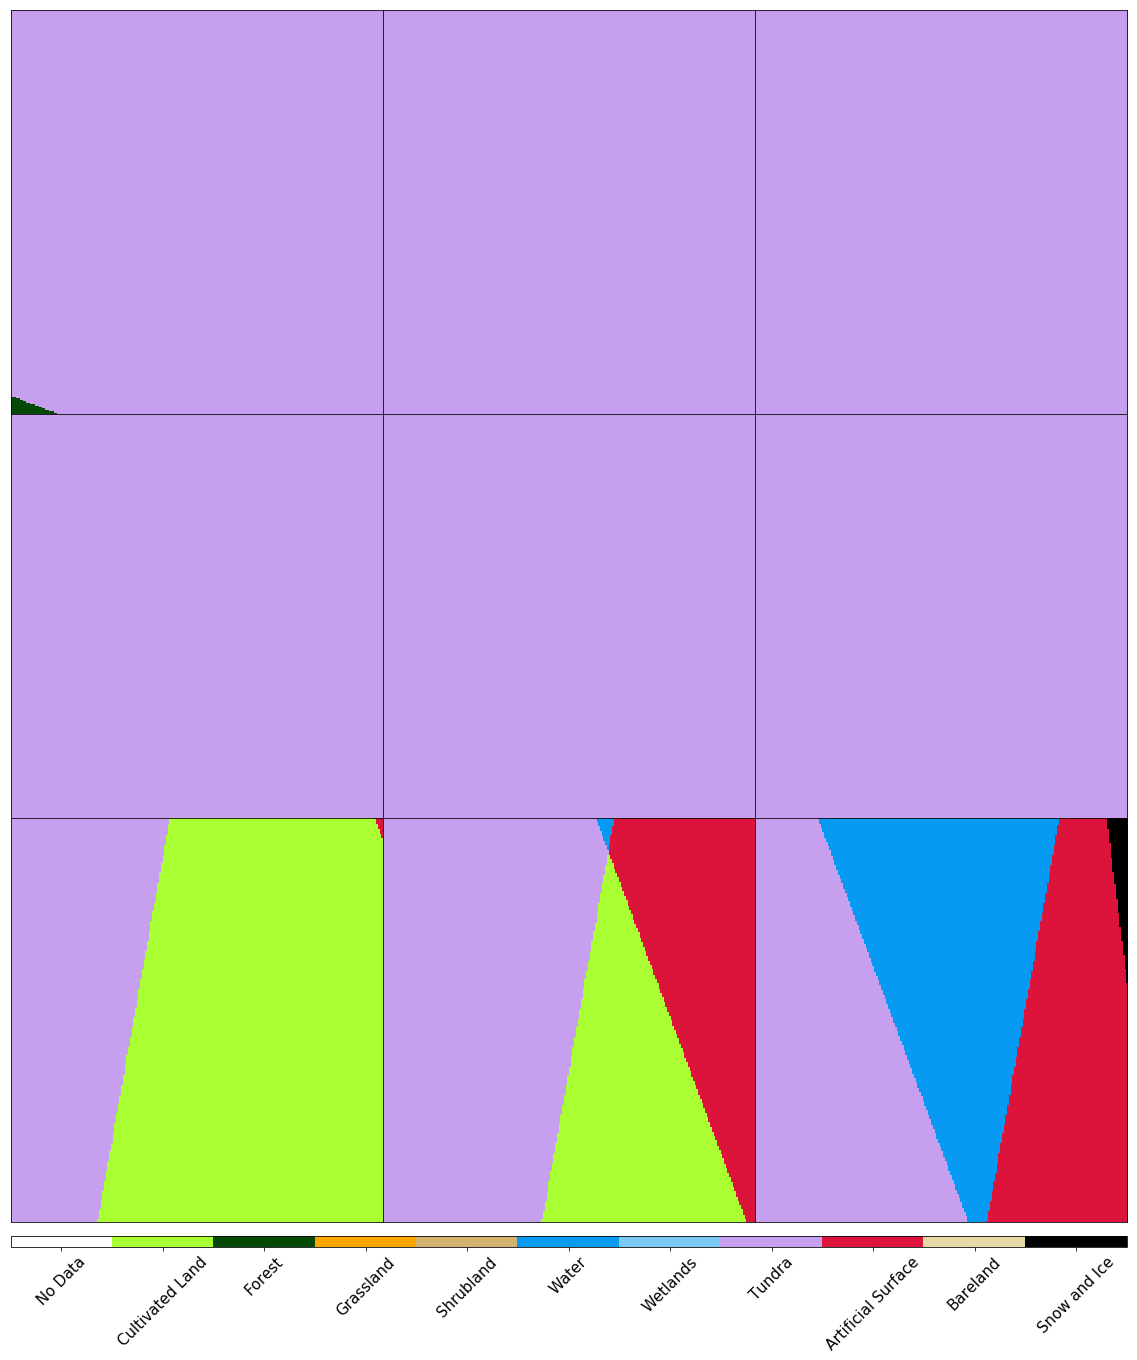

In [72]:
# Содержание geopandas dataframe
gdf.head()

# Выбор варианта визуализации справочной карты
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

# Геометрические параметры областей отображения и их конфигурация
# axes (type = numpy.ndarray)
# fig (type = figure)
fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

# Панель статуса загрузки, пример - ('9/|/100%|| 9/9 [03:29<00:00, 67.30it/s]')
pbar = tqdm(total=9)

# ***.imshow(функция отображения изображений matplotlib первым аргументом принимает X - изображение в формате массива)
# numpy.ndarray.flat - итератор массива, на являющийся подклассом стандартного итератора
# enumerate - создание кортежа № элемента; элемент из итерируемого объекта
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

# Промежутки между областями отображения    
fig.subplots_adjust(wspace=0, hspace=0)

# Легенда 
cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

In [61]:
print(EOPatch)

<class 'eolearn.core.eodata.EOPatch'>
